In [16]:
import sys
sys.path.append('../src/')

import os
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import utils
import config
import joblib

from utils import make_ndarray_from_csv, get_int_label
from collections import Counter, OrderedDict
from matplotlib import rcParams
from imblearn.over_sampling import SMOTE, RandomOverSampler

## Config

In [17]:
# Change option so that pandas always display all rows of the dataframe
pd.set_option('display.max_rows', None)

In [18]:
TAKE_MINOR_AT = -5
fold = '1.0'
mode = 'train'

## Count number of samples for each class

In [19]:
def make_ndarray_from_raw_csv(fold, mode = 'None'):
    dat_cfg = config.data_config
    if mode.lower() == 'train':
        train_csv_path = os.path.join(dat_cfg['RAW_TRAIN_CSV_DIR'], f'{fold}_train.csv')
        df_train = pd.read_csv(train_csv_path, index_col = 0).fillna(0)    
        
        train_features = np.array(df_train.iloc[:,:10000])
        train_labels = np.array(df_train.iloc[:,-2])
        # train_labels = np.array([get_int_label(label) for label in train_labels])
        return train_features, train_labels    
    
    elif mode.lower() == 'test' or mode.lower() == 'val':
        test_csv_path = os.path.join(dat_cfg['RAW_TEST_CSV_DIR'], f'{fold}_test.csv')
        df_test = pd.read_csv(test_csv_path, index_col = 0).fillna(0)
        
        test_features = np.array(df_test.iloc[:,:10000])
        test_labels = np.array(df_test.iloc[:,-2])
        # test_labels = np.array([get_int_label(label) for label in test_labels])
        return test_features, test_labels
    
    elif mode.lower() == 'all':
        train_csv_path = os.path.join(dat_cfg['RAW_TRAIN_CSV_DIR'], f'{fold}_train.csv')
        df_train = pd.read_csv(train_csv_path, index_col = 0).fillna(0)    
        
        train_features = np.array(df_train.iloc[:,:10000])
        train_labels = np.array(df_train.iloc[:,-2])
        
        test_csv_path = os.path.join(dat_cfg['RAW_TEST_CSV_DIR'], f'{fold}_test.csv')
        df_test = pd.read_csv(test_csv_path, index_col = 0).fillna(0)
        
        test_features = np.array(df_test.iloc[:,:10000])
        test_labels = np.array(df_test.iloc[:,-2])
        
        features = np.append(train_features, test_features, axis = 0)
        labels = np.append(train_labels, test_labels, axis = 0)
        # labels = np.array([get_int_label(label) for label in labels])
        
        return features, labels
        
    else:        
        train_csv_path = os.path.join(dat_cfg['RAW_TRAIN_CSV_DIR'], f'{fold}_train.csv')
        test_csv_path = os.path.join(dat_cfg['RAW_TEST_CSV_DIR'], f'{fold}_test.csv')
        df_train = pd.read_csv(train_csv_path, index_col = 0).fillna(0)
        df_test = pd.read_csv(test_csv_path, index_col = 0).fillna(0)
        
        train_features = np.array(df_train.iloc[:,:10000])
        train_labels = np.array(df_train.iloc[:,-2])
        # train_labels = np.array([get_int_label(label) for label in train_labels])
        
        test_features = np.array(df_test.iloc[:,:10000])
        test_labels = np.array(df_test.iloc[:,-2])
        # test_labels = np.array([get_int_label(label) for label in test_labels])
        
        return train_features, train_labels, test_features, test_labels

In [20]:
features, labels = make_ndarray_from_raw_csv(fold, mode = mode)
features.shape, labels.shape

((2204, 10000), (2204,))

In [21]:
labels_count = Counter(labels)

In [22]:
print(labels_count)

Counter({'GBM, RTK II': 114, 'MB, G4': 110, 'LGG, PA PF': 91, 'EPN, PF A': 72, 'MNG': 72, 'MB, SHH CHL AD': 67, 'O IDH': 64, 'DMG, K27': 62, 'A IDH': 62, 'MB, G3': 61, 'EPN, RELA': 56, 'GBM, RTK I': 51, 'GBM, MES': 44, 'MB, SHH INF': 41, 'EPN, PF B': 40, 'ATRT, SHH': 36, 'A IDH, HG': 36, 'PLEX, PED B': 36, 'PXA': 35, 'LGG, DNT': 35, 'ETMR': 34, 'GBM, G34': 32, 'MB, WNT': 31, 'CNS NB, FOXR2': 31, 'LGG, PA MID': 30, 'ATRT, TYR': 29, 'SUBEPN, PF': 29, 'ATRT, MYC': 23, 'PITUI': 23, 'EPN, MPE': 22, 'EPN, SPINE': 21, 'HMB': 20, 'CPH, ADM': 20, 'LGG, PA/GG ST': 19, 'CONTR, INFLAM': 19, 'CONTR, REACT': 18, 'HGNET, BCOR': 18, 'SCHW': 18, 'ENB, A': 18, 'LGG, MYB': 17, 'PIN T,  PB B': 17, 'PTPR, B': 17, 'PLEX, AD': 17, 'HGNET, MN1': 16, 'LGG, SEGA': 16, 'CN': 16, 'CPH, PAP': 16, 'LGG, GG': 16, 'PITAD, FSH LH': 16, 'ANA PA': 16, 'SUBEPN, ST': 15, 'PIN T, PPT': 15, 'PGG, nC': 15, 'RETB': 15, 'PITAD, ACTH': 14, 'PITAD, STH SPA': 13, 'GBM, MYCN': 12, 'ENB, B': 12, 'SFT HMPC': 12, 'MELCYT': 12, 'PLEX,

In [23]:
sorted_labels_count = OrderedDict(labels_count.most_common())
print(sorted_labels_count)

OrderedDict([('GBM, RTK II', 114), ('MB, G4', 110), ('LGG, PA PF', 91), ('EPN, PF A', 72), ('MNG', 72), ('MB, SHH CHL AD', 67), ('O IDH', 64), ('DMG, K27', 62), ('A IDH', 62), ('MB, G3', 61), ('EPN, RELA', 56), ('GBM, RTK I', 51), ('GBM, MES', 44), ('MB, SHH INF', 41), ('EPN, PF B', 40), ('ATRT, SHH', 36), ('A IDH, HG', 36), ('PLEX, PED B', 36), ('PXA', 35), ('LGG, DNT', 35), ('ETMR', 34), ('GBM, G34', 32), ('MB, WNT', 31), ('CNS NB, FOXR2', 31), ('LGG, PA MID', 30), ('ATRT, TYR', 29), ('SUBEPN, PF', 29), ('ATRT, MYC', 23), ('PITUI', 23), ('EPN, MPE', 22), ('EPN, SPINE', 21), ('HMB', 20), ('CPH, ADM', 20), ('LGG, PA/GG ST', 19), ('CONTR, INFLAM', 19), ('CONTR, REACT', 18), ('HGNET, BCOR', 18), ('SCHW', 18), ('ENB, A', 18), ('LGG, MYB', 17), ('PIN T,  PB B', 17), ('PTPR, B', 17), ('PLEX, AD', 17), ('HGNET, MN1', 16), ('LGG, SEGA', 16), ('CN', 16), ('CPH, PAP', 16), ('LGG, GG', 16), ('PITAD, FSH LH', 16), ('ANA PA', 16), ('SUBEPN, ST', 15), ('PIN T, PPT', 15), ('PGG, nC', 15), ('RETB', 1

In [24]:
df = pd.DataFrame.from_dict(sorted_labels_count, orient='index').reset_index()
df = df.rename(columns = {'index':'labels', 0:'samples'})
print(df.to_string())
# df

              labels  samples
0        GBM, RTK II      114
1             MB, G4      110
2         LGG, PA PF       91
3          EPN, PF A       72
4                MNG       72
5     MB, SHH CHL AD       67
6              O IDH       64
7           DMG, K27       62
8              A IDH       62
9             MB, G3       61
10         EPN, RELA       56
11        GBM, RTK I       51
12          GBM, MES       44
13       MB, SHH INF       41
14         EPN, PF B       40
15         ATRT, SHH       36
16         A IDH, HG       36
17       PLEX, PED B       36
18               PXA       35
19          LGG, DNT       35
20              ETMR       34
21          GBM, G34       32
22           MB, WNT       31
23     CNS NB, FOXR2       31
24       LGG, PA MID       30
25         ATRT, TYR       29
26        SUBEPN, PF       29
27         ATRT, MYC       23
28             PITUI       23
29          EPN, MPE       22
30        EPN, SPINE       21
31               HMB       20
32        

In [25]:
total_samples = np.sum(df['samples'])
total_samples

2204

## Visualization

In [26]:
classes = np.array(df.iloc[:,0])
n_samples = np.array(df.iloc[:,-1])
counts = df['labels'].value_counts().reset_index(name = 'samples')
print(labels.shape, n_samples.shape)

(2204,) (91,)


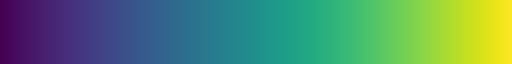

In [43]:
sns.set(font_scale=1)
# test color for sns graph pallette
'''
Possible palette values include:
Name of a seaborn palette (deep, muted, bright, pastel, dark, colorblind)

Name of matplotlib colormap (check here: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)

‘husl’ or ‘hls’

‘ch:<cubehelix arguments>’

‘light:<color>’, ‘dark:<color>’, ‘blend:<color>,<color>’,

A sequence of colors in any format matplotlib accepts
'''
graph_palette = "viridis"
sns.color_palette(graph_palette, as_cmap=True)

### All class group data distribution

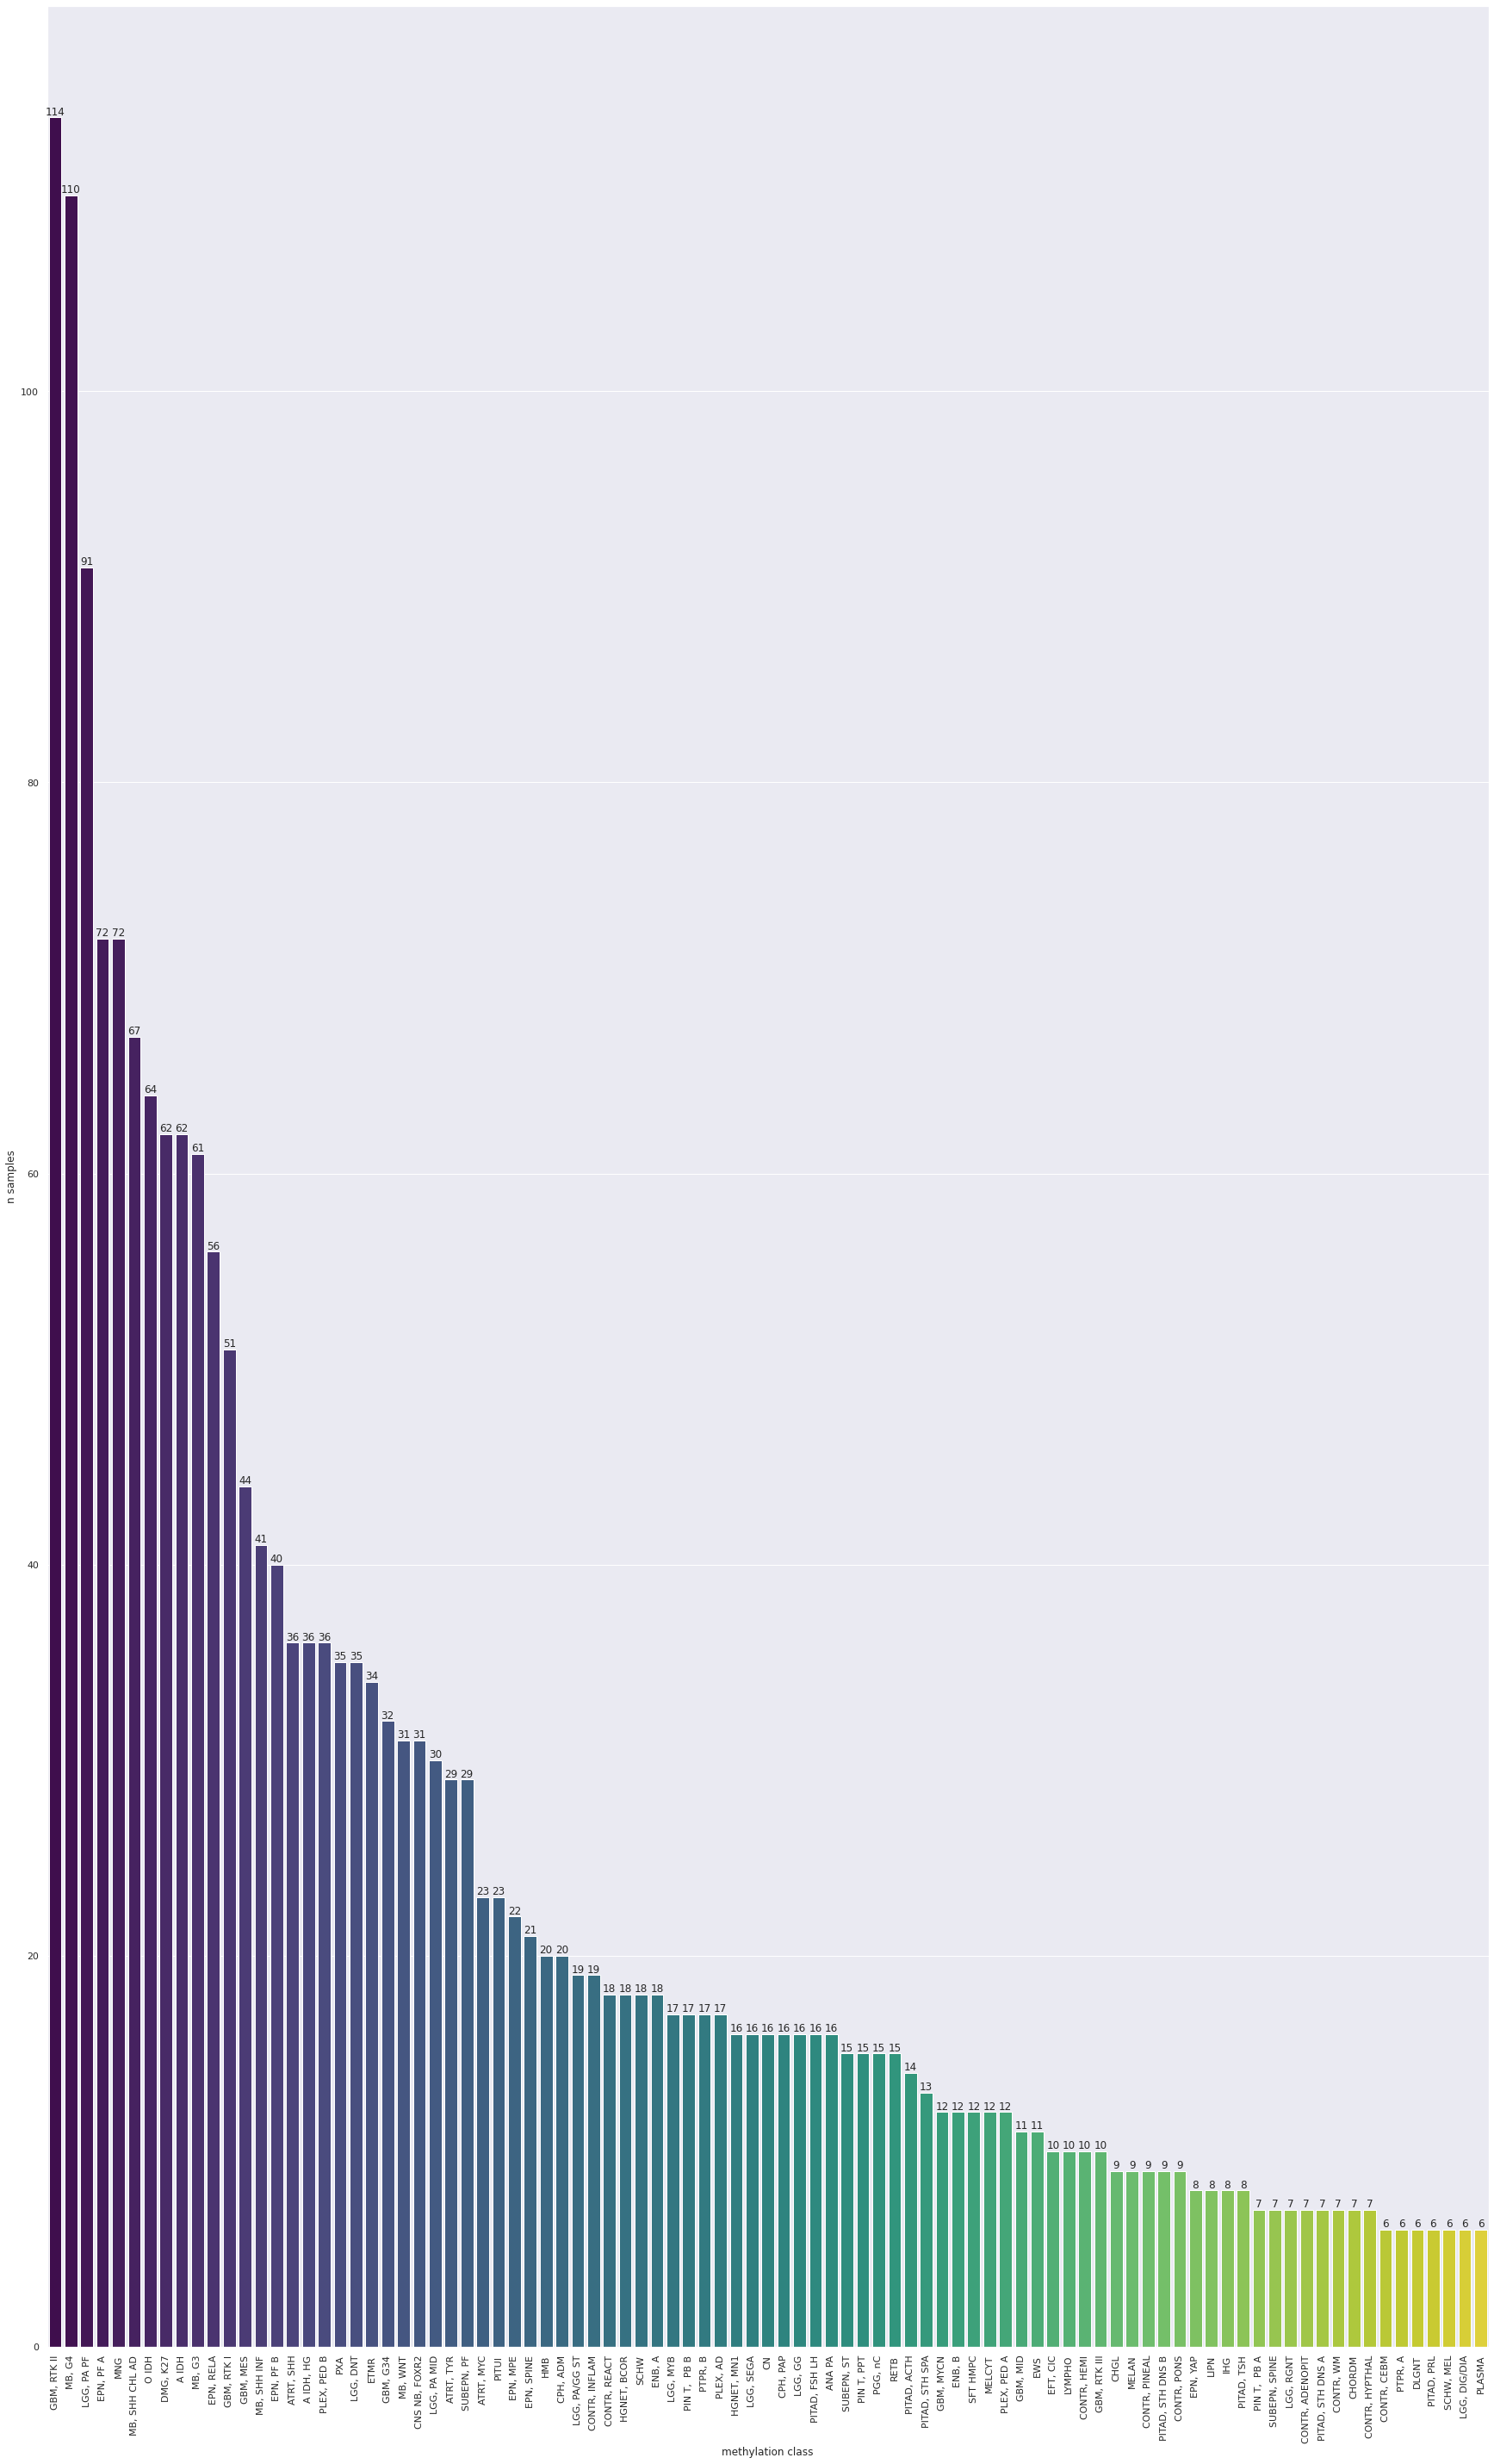

In [44]:
rcParams['figure.figsize'] = 30, 50
graph = sns.barplot(x = classes, y = n_samples, data = counts, palette = graph_palette)
graph.tick_params(axis='x', rotation=90)
graph.bar_label(graph.containers[0])
graph.set_ylabel('n samples')
graph.set_xlabel('methylation class')
plt.show()

### Each class group data distribution

['Embryonal', 'Glioblastoma', 'Glio-neuronal', 'Sella', 'Ependymal', 'Other glioma', 'Nerve', 'Pineal', 'Mesenchymal', 'Melanocytic', 'Plexus', 'Glioma IDH', 'Haematopoietic']


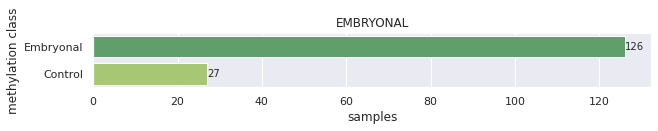

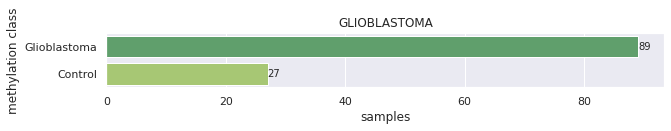

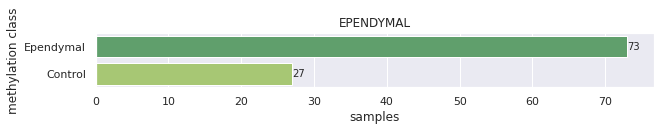

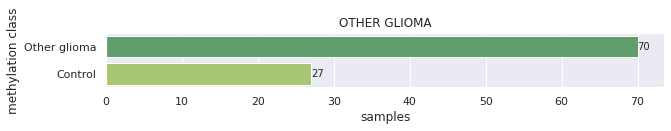

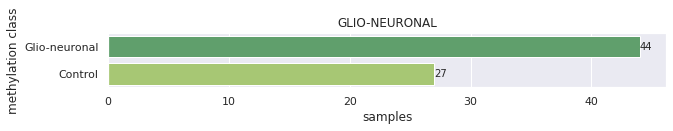

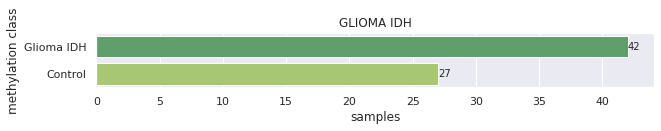

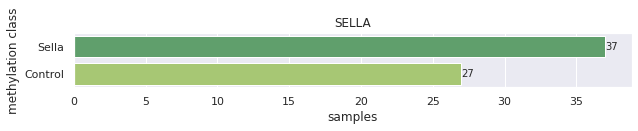

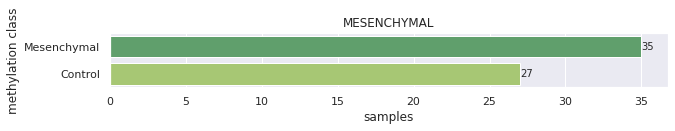

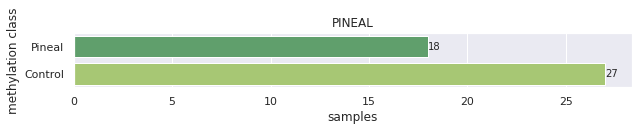

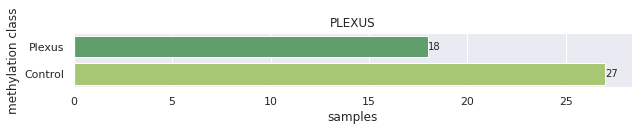

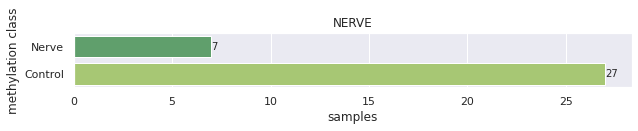

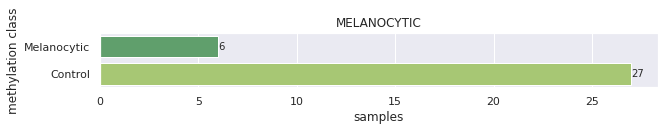

In [15]:
groups = utils.positive_groups
print(groups)
for i in range(len(groups)):
    group = df.iloc[i,:]['labels']
    if group == 'Control':
        continue
    group_counts = df.iloc[i,:]['samples']
    control_counts = df.loc[df['labels'] == 'Control']['samples'].item()
    control = "Control"
    others_counts = total_samples - group_counts - control_counts
    others = "Others"
    
    rcParams['figure.figsize'] = 10, 1
    graph = sns.barplot(x = [group_counts, control_counts], y = [group, control], palette = graph_palette)
    graph.bar_label(graph.containers[0])
    graph.set_xlabel('samples')
    graph.set_ylabel('methylation class')
    graph.set_title(f'{group.upper()}')
    plt.show()

## Tackle the imbalanced class distribution

#### SMOTE

In [16]:
X = features
y = labels
print(np.unique(labels))
print(np.unique(y))

['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Haematopoietic' 'Melanocytic' 'Mesenchymal' 'Nerve'
 'Other glioma' 'Pineal' 'Plexus' 'Sella']
['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Haematopoietic' 'Melanocytic' 'Mesenchymal' 'Nerve'
 'Other glioma' 'Pineal' 'Plexus' 'Sella']


In [17]:
minor_classes = list(sorted_labels_count.keys())[TAKE_MINOR_AT:]
print(minor_classes)

['Pineal', 'Plexus', 'Nerve', 'Melanocytic', 'Haematopoietic']


In [18]:
minor_indexes = []
i = 0
for label in labels:
    if label in minor_classes:
        minor_indexes.append(i)
    i += 1
print(len(minor_indexes))

54


In [19]:
minor_fetures = np.array([features[i] for i in minor_indexes])
minor_labels = np.array([labels[i] for i in minor_indexes])
major_features = np.array([features[i] for i in range(len(features)) if i not in minor_indexes])
major_labels = np.array([labels[i] for i in range(len(features)) if i not in minor_indexes])
print(np.unique(minor_labels), len(np.unique(minor_labels)))
print(np.unique(major_labels), len(np.unique(major_labels)))
print(len(minor_fetures), len(major_features))
print(len(minor_labels), len(major_features))

['Haematopoietic' 'Melanocytic' 'Nerve' 'Pineal' 'Plexus'] 5
['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Mesenchymal' 'Other glioma' 'Sella'] 9
54 543
54 543


In [20]:
X_minor = minor_fetures
y_minor = minor_labels
X_major = major_features
y_major = major_labels
print(np.unique(y_major),'\n' ,np.unique(y_minor))

['Control' 'Embryonal' 'Ependymal' 'Glio-neuronal' 'Glioblastoma'
 'Glioma IDH' 'Mesenchymal' 'Other glioma' 'Sella'] 
 ['Haematopoietic' 'Melanocytic' 'Nerve' 'Pineal' 'Plexus']


In [21]:
smote = SMOTE(sampling_strategy = "auto", random_state = 42, k_neighbors = 4)
new_X_minor, new_y_minor = smote.fit_resample(X_minor, y_minor)

In [22]:
print(type(new_X_minor), type(new_y_minor), len(new_X_minor), len(new_y_minor))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 90 90


In [23]:
new_X = np.append(X_major, new_X_minor, axis = 0)
new_y = np.append(y_major, new_y_minor)
print(len(new_X), len(new_y))

633 633
